In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [13]:
def load_and_explore_data(file_path):
    # Load data
    df = pd.read_csv(file_path)
   
    print("1. Basic Dataset Information:")
    print("-" * 50)
    print(f"Shape of dataset: {df.shape}")
    print("\nFirst few rows:")
    print(df.head())
    print("\nData Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nDuplicate Rows:", df.duplicated().sum())
    
    # Clean the data
    df.drop(columns=['Series_Title'], inplace=True)
    df.drop(columns=['Overview'], inplace=True)
    df.drop(columns=['Genre'], inplace=True)
    df.drop(columns=['Director'], inplace=True)
    df.drop(columns=['Star'], inplace=True)
    df.drop(columns=['Certificate'], inplace=True)
    
    # Convert Gross to numeric
    df['Gross'] = df['Gross'].str.replace(',', '')
    df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce')
    
    # Convert Runtime to numeric
    df['Runtime'] = df['Runtime'].str.replace(' min', '').astype(int)
   
    return df

In [4]:
def perform_eda(df):
    print("\n2. Detailed EDA")
    print("-" * 50)
   
    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
   
    print("\nNumerical Columns:", numerical_cols.tolist())
    print("Categorical Columns:", categorical_cols.tolist())
   
    # Univariate Analysis
    print("\n2.1 Univariate Analysis")
    print("-" * 30)
   
    # For numerical columns
    print("\nNumerical Columns Summary:")
    print(df[numerical_cols].describe())
   
    # For categorical columns
    print("\nCategorical Columns Summary:")
    for col in categorical_cols:
        print(f"\n{col} value counts:")
        print(df[col].value_counts().head(10))  # Show only top 10
        print(f"{col} unique values:", df[col].nunique())
   
    # Bivariate Analysis
    print("\n2.2 Bivariate Analysis")
    print("-" * 30)
   
    # Correlation matrix for numerical columns
    if len(numerical_cols) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = df[numerical_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()
   
    return numerical_cols, categorical_cols

In [5]:
def preprocess_data_for_clustering(df, numerical_cols, categorical_cols):
    print("\n3. Data Preprocessing for Clustering")
    print("-" * 50)
   
    # Create a copy to avoid modifying original data
    df_processed = df.copy()
    
    # For clustering, we'll drop the target columns (Meta_score and Gross)
    # as mentioned in your requirement
    if 'Meta_score' in df_processed.columns:
        df_processed.drop(columns=['Meta_score'], inplace=True, errors='ignore')
    if 'Gross' in df_processed.columns:
        df_processed.drop(columns=['Gross'], inplace=True, errors='ignore')
   
    # Handle missing values
    print("\n3.1 Handling Missing Values")
    for col in df_processed.columns:
        if df_processed[col].isnull().sum() > 0:
            if col in numerical_cols:
                # Fill numerical missing values with median
                df_processed[col].fillna(df_processed[col].median(), inplace=True)
            else:
                # Fill categorical missing values with mode
                df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
   
    # Remove duplicates
    df_processed.drop_duplicates(inplace=True)
   
    # Encode categorical variables
    print("\n3.2 Encoding Categorical Variables")
    label_encoders = {}
    for col in categorical_cols:
        if col in df_processed.columns:  # Make sure column exists
            label_encoders[col] = LabelEncoder()
            df_processed[col] = label_encoders[col].fit_transform(df_processed[col])
   
    # Scale numerical features
    print("\n3.3 Scaling Numerical Features")
    numerical_cols_present = [col for col in numerical_cols if col in df_processed.columns]
    scaler = StandardScaler()
    
    if numerical_cols_present:
        df_processed[numerical_cols_present] = scaler.fit_transform(df_processed[numerical_cols_present])
   
    print("\nFinal dataset shape for clustering:", df_processed.shape)
   
    return df_processed, scaler, label_encoders

In [6]:
def find_optimal_clusters(data, max_k=10):
    print("\n4. Finding Optimal Number of Clusters (Elbow Method)")
    print("-" * 50)
    
    inertia = []
    silhouette_scores = []
    db_scores = []
    k_values = range(2, max_k + 1)
    
    for k in k_values:
        print(f"\rAnalyzing k={k}/{max_k}...", end="")
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
        
        # Calculate silhouette score
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)
        
        # Calculate Davies-Bouldin Index
        db_index = davies_bouldin_score(data, labels)
        db_scores.append(db_index)
    
    print("\n")
    
    # Plot elbow method
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(k_values, inertia, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(k_values, silhouette_scores, 'go-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method')
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(k_values, db_scores, 'ro-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Davies-Bouldin Index')
    plt.title('Davies-Bouldin Index')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print the metrics in a table
    results_df = pd.DataFrame({
        'K': k_values,
        'Inertia': inertia,
        'Silhouette Score': silhouette_scores,
        'Davies-Bouldin Index': db_scores
    })
    
    print("\nClustering Performance Metrics:")
    print(results_df)
    
    # Determine optimal k
    # For silhouette, higher is better
    optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
    # For Davies-Bouldin, lower is better
    optimal_k_db = k_values[np.argmin(db_scores)]
    
    print(f"\nOptimal k according to Silhouette Score: {optimal_k_silhouette}")
    print(f"Optimal k according to Davies-Bouldin Index: {optimal_k_db}")
    
    return optimal_k_silhouette, results_df

In [7]:
def perform_kmeans_clustering(data, n_clusters, original_df):
    print(f"\n5. Performing K-means Clustering with {n_clusters} clusters")
    print("-" * 50)
    
    # Apply K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(data)
    
    # Get cluster labels
    labels = kmeans.labels_
    
    # Add cluster labels to the original dataframe for analysis
    df_with_clusters = original_df.copy()
    df_with_clusters['Cluster'] = labels
    
    # Calculate performance metrics
    silhouette_avg = silhouette_score(data, labels)
    db_index = davies_bouldin_score(data, labels)
    
    print(f"\nSilhouette Score: {silhouette_avg:.4f}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    
    return kmeans, df_with_clusters, labels

In [8]:
def visualize_clusters(data, labels, n_clusters, centers=None):
    print("\n6. Visualizing Clusters")
    print("-" * 50)
    
    # Apply PCA to reduce dimensions to 2 for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    
    # If centers are provided, also transform them
    if centers is not None:
        reduced_centers = pca.transform(centers)
    
    # Plot the clusters
    plt.figure(figsize=(12, 10))
    
    # Create a scatter plot for each cluster
    for i in range(n_clusters):
        # Get points in this cluster
        cluster_points = reduced_data[labels == i]
        plt.scatter(
            cluster_points[:, 0], 
            cluster_points[:, 1], 
            s=50, 
            label=f'Cluster {i}'
        )
    
    # Plot the centroids if provided
    if centers is not None:
        plt.scatter(
            reduced_centers[:, 0], 
            reduced_centers[:, 1],
            s=200, 
            marker='X', 
            c='red', 
            label='Centroids'
        )
    
    plt.title(f'Clusters Visualization with PCA (k={n_clusters})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Display explained variance of PCA
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio of the two principal components: {explained_variance}")
    print(f"Total variance explained: {sum(explained_variance):.4f}")
    
    return reduced_data, pca

In [9]:
def analyze_clusters(df_with_clusters, n_clusters, original_columns):
    print("\n7. Cluster Analysis")
    print("-" * 50)
    
    # Analyze the distribution of features across clusters
    cluster_stats = df_with_clusters.groupby('Cluster')[original_columns].mean()
    print("\nCluster Centers (Mean Values):")
    print(cluster_stats)
    
    # Visualize feature distribution by cluster
    for feature in original_columns:
        if feature in df_with_clusters.columns:  # Make sure column exists
            plt.figure(figsize=(12, 6))
            
            # Box plot of feature by cluster
            plt.subplot(1, 2, 1)
            sns.boxplot(x='Cluster', y=feature, data=df_with_clusters)
            plt.title(f'Distribution of {feature} by Cluster')
            
            # Bar plot of mean feature value by cluster
            plt.subplot(1, 2, 2)
            sns.barplot(x=cluster_stats.index, y=feature, data=cluster_stats.reset_index())
            plt.title(f'Mean {feature} by Cluster')
            
            plt.tight_layout()
            plt.show()
    
    # Size of each cluster
    cluster_sizes = df_with_clusters['Cluster'].value_counts().sort_index()
    print("\nCluster Sizes:")
    print(cluster_sizes)
    
    # Visualize cluster sizes
    plt.figure(figsize=(10, 6))
    cluster_sizes.plot(kind='bar')
    plt.title('Number of Samples in Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.grid(True, axis='y')
    plt.show()
    
    return cluster_stats, cluster_sizes

In [10]:
def interpret_results(cluster_stats, cluster_sizes, n_clusters, original_df):
    """
    Provide interpretation of the clustering results
    """
    print("\n8. Results Interpretation")
    print("-" * 50)
    
    # Calculate the percentage of data in each cluster
    total_samples = sum(cluster_sizes)
    cluster_percentages = (cluster_sizes / total_samples * 100).round(2)
    
    print("\nCluster Distribution:")
    for i in range(n_clusters):
        print(f"Cluster {i}: {cluster_sizes[i]} samples ({cluster_percentages[i]}% of total)")
    
    # Analyze distinctive features for each cluster
    print("\nDistinctive Features of Each Cluster:")
    for i in range(n_clusters):
        # For each feature, calculate how far it is from the overall mean
        cluster_profile = {}
        for feature in cluster_stats.columns:
            overall_mean = original_df[feature].mean()
            cluster_mean = cluster_stats.loc[i, feature]
            # Calculate the difference as a percentage of the overall mean
            if overall_mean != 0:
                diff_percentage = ((cluster_mean - overall_mean) / abs(overall_mean)) * 100
            else:
                diff_percentage = cluster_mean * 100  # If overall mean is 0
            
            cluster_profile[feature] = diff_percentage
        
        # Sort the features by absolute difference
        sorted_features = sorted(
            cluster_profile.items(), 
            key=lambda x: abs(x[1]), 
            reverse=True
        )
        
        # Print the top distinctive features
        print(f"\nCluster {i} distinct characteristics:")
        for feature, diff_pct in sorted_features[:3]:  # Top 3 distinctive features
            direction = "higher" if diff_pct > 0 else "lower"
            print(f"  - {feature}: {abs(diff_pct):.2f}% {direction} than average")
    
    # Overall clustering quality assessment
    print("\nOverall Clustering Quality Assessment:")

1. Basic Dataset Information:
--------------------------------------------------
Shape of dataset: (650, 12)

First few rows:
               Series_Title  Released_Year Certificate  Runtime  \
0  The Shawshank Redemption           1994           A  142 min   
1             The Godfather           1972           A  175 min   
2           The Dark Knight           2008          UA  152 min   
3    The Godfather: Part II           1974           A  202 min   
4              12 Angry Men           1957           U   96 min   

                  Genre  IMDB_Rating  \
0                 Drama          9.3   
1          Crime, Drama          9.2   
2  Action, Crime, Drama          9.0   
3          Crime, Drama          9.0   
4          Crime, Drama          9.0   

                                            Overview  Meta_score  \
0  Two imprisoned men bond over a number of years...        80.0   
1  An organized crime dynasty's aging patriarch t...       100.0   
2  When the menace known a

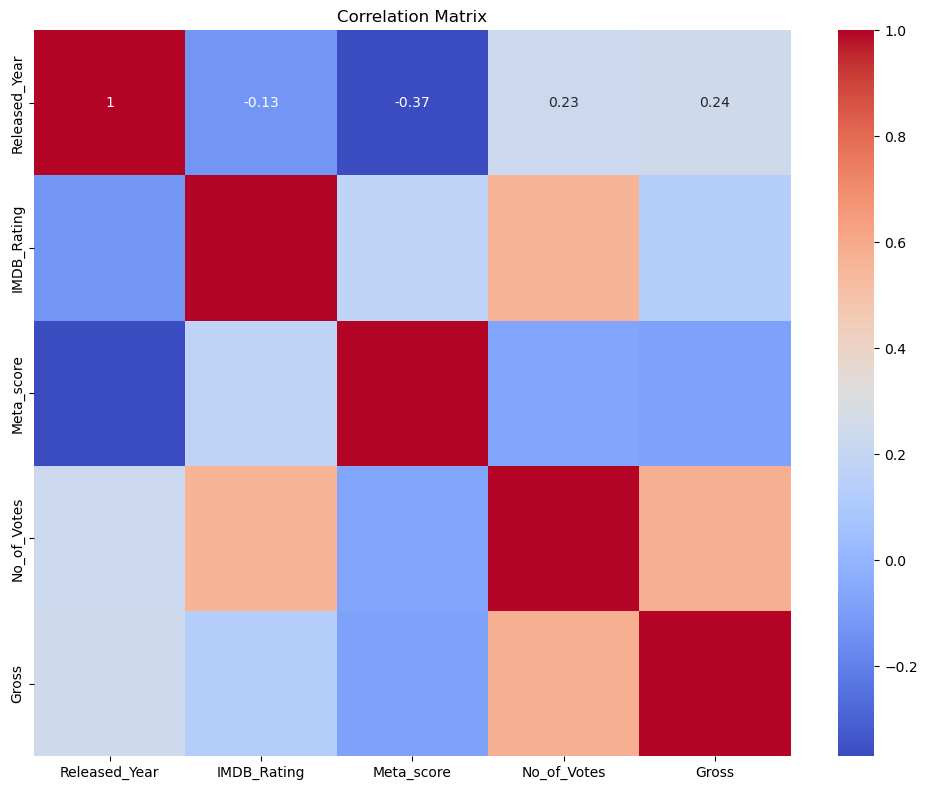


3. Data Preprocessing for Clustering
--------------------------------------------------

3.1 Handling Missing Values

3.2 Encoding Categorical Variables

3.3 Scaling Numerical Features

Final dataset shape for clustering: (650, 4)

4. Finding Optimal Number of Clusters (Elbow Method)
--------------------------------------------------
Analyzing k=10/10...



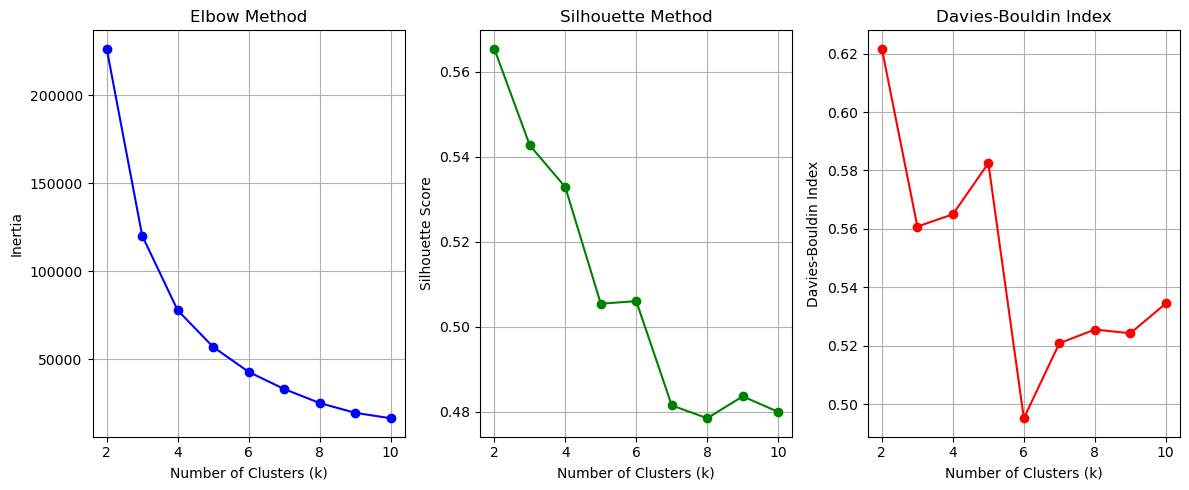


Clustering Performance Metrics:
    K        Inertia  Silhouette Score  Davies-Bouldin Index
0   2  226380.968509          0.565386              0.621671
1   3  120082.021190          0.542675              0.560802
2   4   77683.974573          0.532850              0.565002
3   5   56846.645750          0.505407              0.582510
4   6   42676.992826          0.506014              0.495152
5   7   32946.570214          0.481477              0.520815
6   8   24981.378359          0.478456              0.525535
7   9   19412.127002          0.483605              0.524253
8  10   16326.025424          0.479957              0.534451

Optimal k according to Silhouette Score: 2
Optimal k according to Davies-Bouldin Index: 6

5. Performing K-means Clustering with 2 clusters
--------------------------------------------------

Silhouette Score: 0.5654
Davies-Bouldin Index: 0.6217

6. Visualizing Clusters
--------------------------------------------------


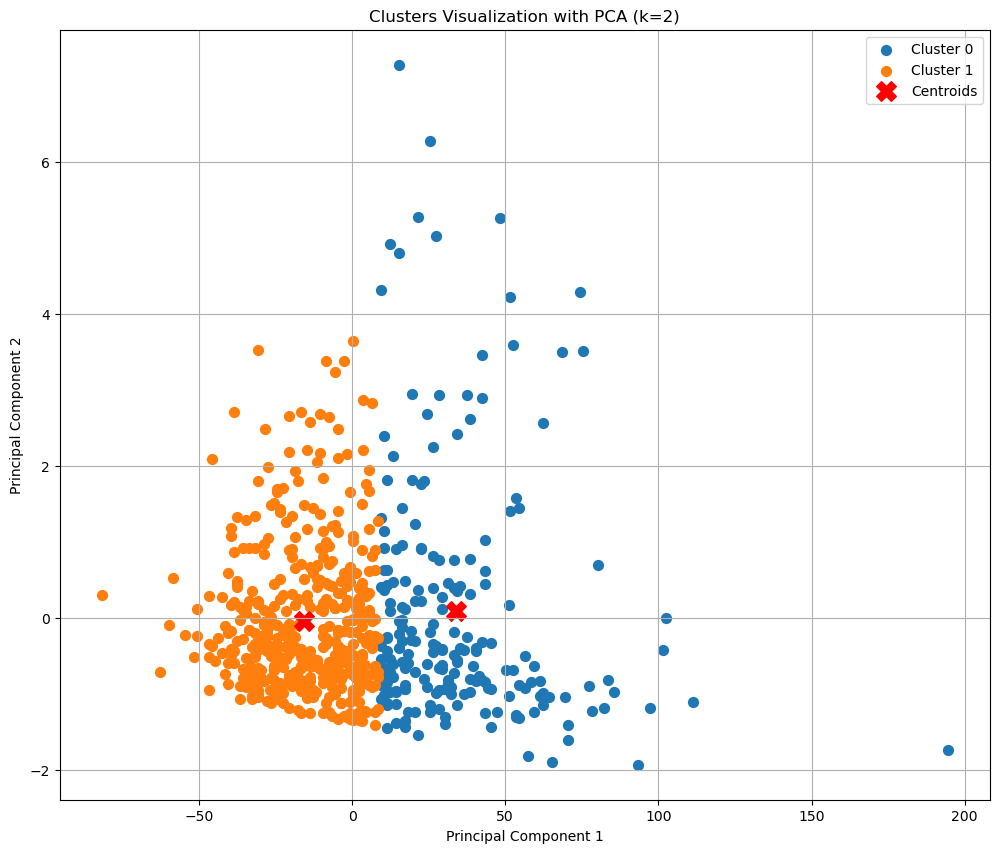

Explained variance ratio of the two principal components: [0.99671226 0.00169624]
Total variance explained: 0.9984

7. Cluster Analysis
--------------------------------------------------

Cluster Centers (Mean Values):
         Released_Year     Runtime  IMDB_Rating    No_of_Votes
Cluster                                                       
0          1995.782609  160.502415     8.158937  407668.053140
1          1988.252822  110.778781     8.060271  282733.261851


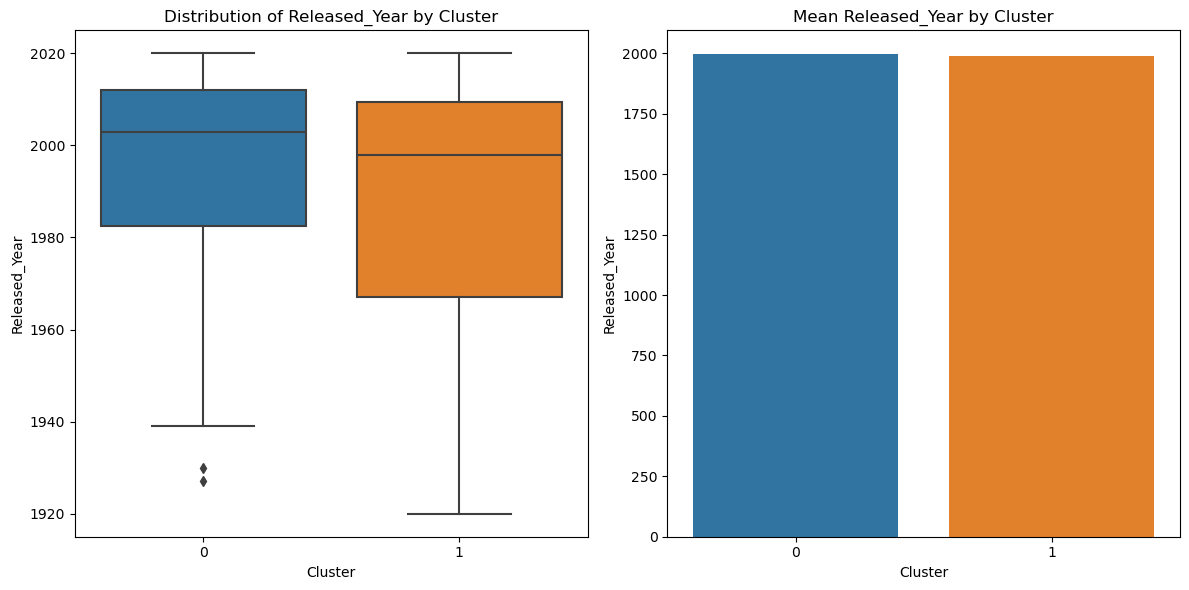

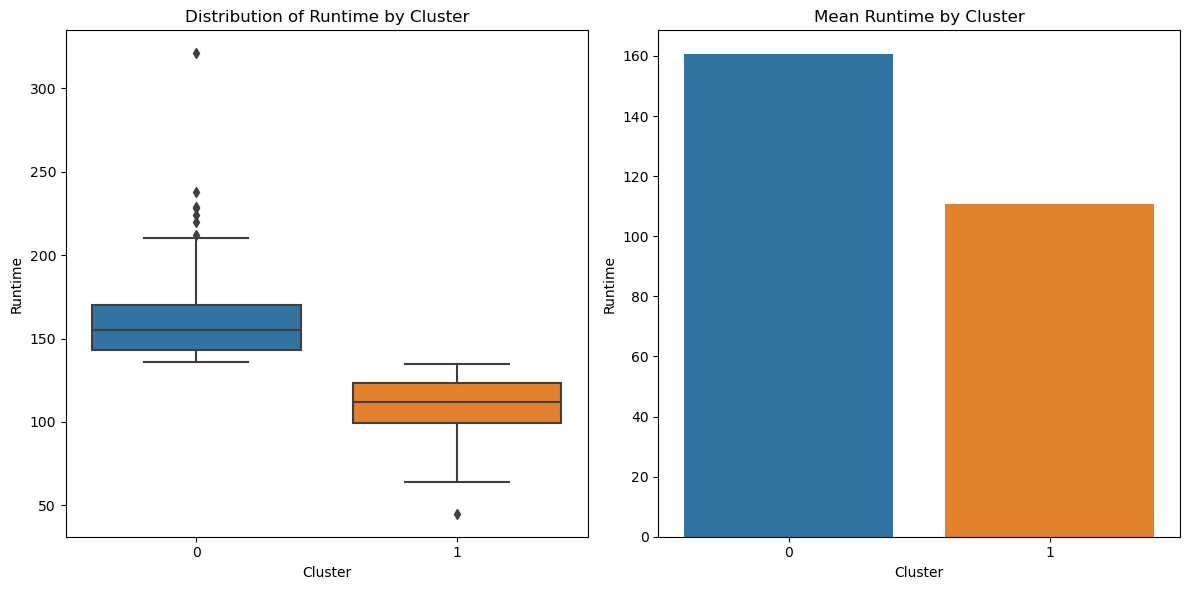

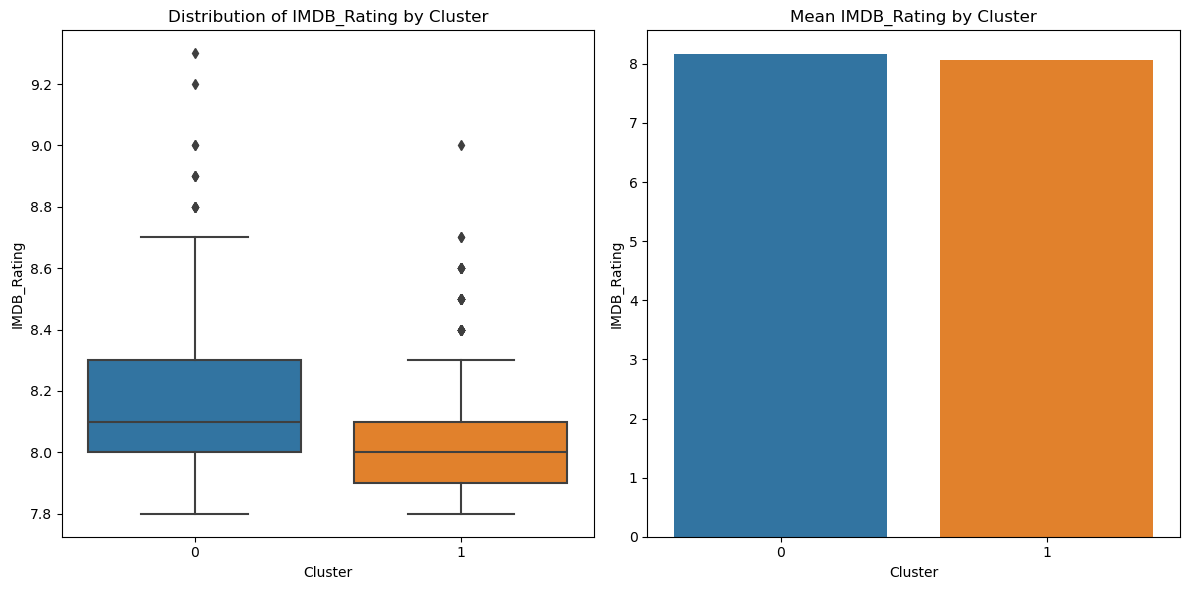

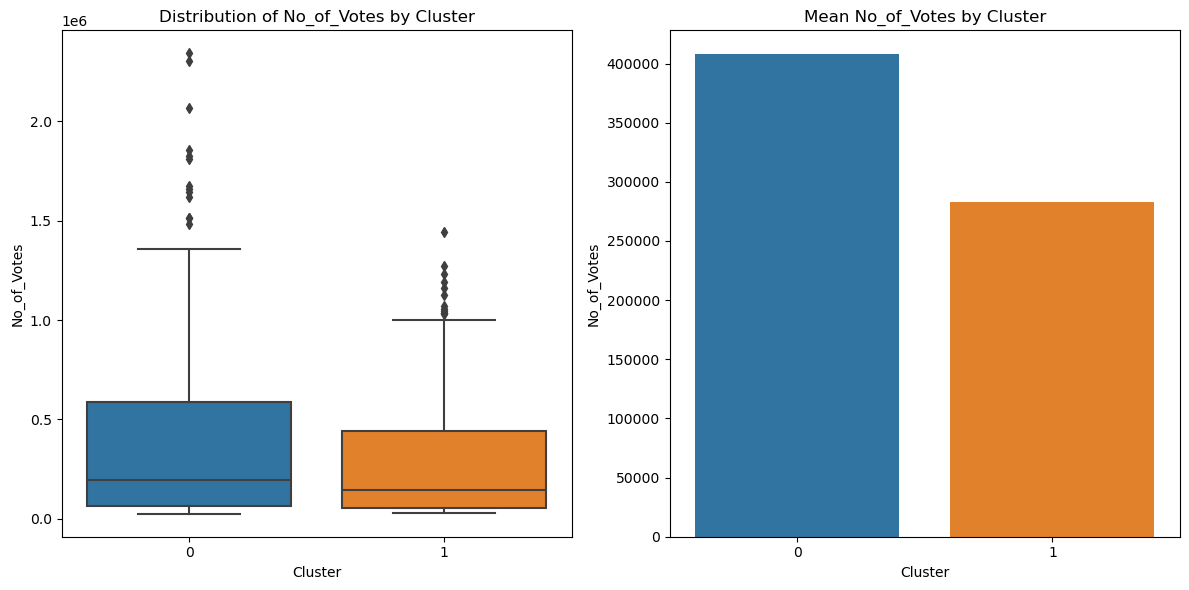


Cluster Sizes:
Cluster
0    207
1    443
Name: count, dtype: int64


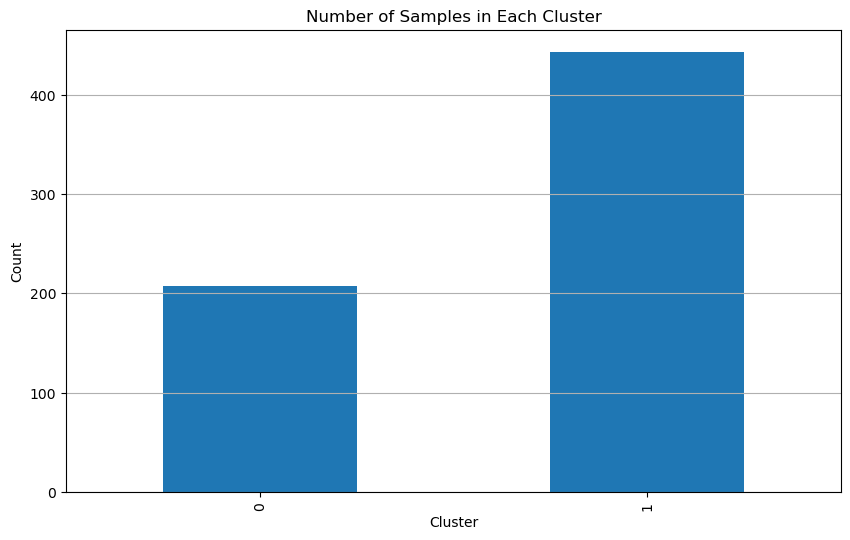


8. Results Interpretation
--------------------------------------------------

Cluster Distribution:
Cluster 0: 207 samples (31.85% of total)
Cluster 1: 443 samples (68.15% of total)

Distinctive Features of Each Cluster:

Cluster 0 distinct characteristics:
  - Runtime: 26.77% higher than average
  - No_of_Votes: 26.40% higher than average
  - IMDB_Rating: 0.83% higher than average

Cluster 1 distinct characteristics:
  - Runtime: 12.51% lower than average
  - No_of_Votes: 12.34% lower than average
  - IMDB_Rating: 0.39% lower than average

Overall Clustering Quality Assessment:

Clustering Analysis Complete!


In [14]:
def run_kmeans_analysis(file_path):

    # Load and explore data
    df = load_and_explore_data(file_path)
    
    # Perform EDA
    numerical_cols, categorical_cols = perform_eda(df)
    
    # Preprocess data for clustering
    df_processed, scaler, label_encoders = preprocess_data_for_clustering(df, numerical_cols, categorical_cols)
    
    # Find optimal number of clusters
    optimal_k, metrics_df = find_optimal_clusters(df_processed, max_k=10)
    
    # Perform K-means with optimal clusters
    kmeans, df_with_clusters, labels = perform_kmeans_clustering(
        df_processed, optimal_k, df
    )
    
    # Visualize clusters
    reduced_data, pca = visualize_clusters(
        df_processed, labels, optimal_k, kmeans.cluster_centers_
    )
    
    # Get original columns for analysis (excluding Meta_score and Gross which were dropped)
    original_columns = [col for col in df.columns if col not in ['Meta_score', 'Gross']]
    
    # Analyze clusters
    cluster_stats, cluster_sizes = analyze_clusters(
        df_with_clusters, optimal_k, original_columns
    )
    
    # Interpret results
    interpret_results(cluster_stats, cluster_sizes, optimal_k, df)
    
    return kmeans, df_with_clusters, metrics_df

if __name__ == "__main__":
    file_path = "./IMDB_Dataset.csv" 
    kmeans, clustered_df, metrics = run_kmeans_analysis(file_path)
    
    print("\nClustering Analysis Complete!")

Based on the results of your K-means clustering analysis, here's a comprehensive inference:
Overall Clustering Performance
The analysis suggests that dividing your movie dataset into 2 clusters provides the optimal solution according to the Silhouette Score (0.5654), while 6 clusters would be optimal according to the Davies-Bouldin Index (0.495152). Since you proceeded with 2 clusters and achieved a good Silhouette Score of 0.5654 (values closer to 1 indicate better-defined clusters), this appears to be a solid clustering solution.
Cluster Distribution and Characteristics
Your dataset was divided into two distinct clusters with an uneven distribution:

Cluster 0: 207 movies (31.85% of the dataset)
Cluster 1: 443 movies (68.15% of the dataset)

Cluster 0: "Premium/Blockbuster Movies"
This smaller cluster appears to represent higher-profile, longer, and more popular films:

Runtime: 26.77% longer than average
Number of Votes: 26.40% higher than average
IMDB Rating: 0.83% higher than average

These characteristics suggest movies that are more substantial in length and receive more attention from audiences (higher vote counts). The slightly higher IMDB ratings indicate these films are marginally better received critically, though the difference is small.
Cluster 1: "Standard/Mainstream Movies"
This larger cluster represents the majority of films in your dataset:

Runtime: 12.51% shorter than average
Number of Votes: 12.34% lower than average
IMDB Rating: 0.39% lower than average

These films tend to be shorter in duration and receive less audience attention (fewer votes). Their ratings are only slightly below average, suggesting quality isn't dramatically different from Cluster 0.